In [51]:
import numpy as np
import pandas as pd
from scipy.stats import norm, probplot, yeojohnson
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

## Load SMI data

Data source: https://data.snb.ch/de/topics/finma/cube/capchstocki?fromDate=2020-01-01&toDate=2024-12-22

In [2]:
raw = pd.read_csv("data/snb-data-pivoted-all-20241121_0900.csv", parse_dates=["Date"], index_col="Date")

# Strategy following Box-Jenkins

1. Data exploration & preparation
2. Model the time series (trend, ARIMA, GARCH)
3. Forecasting
4. Validation

## 1) Data exploration

### 1.1) Visualization and basic description of data

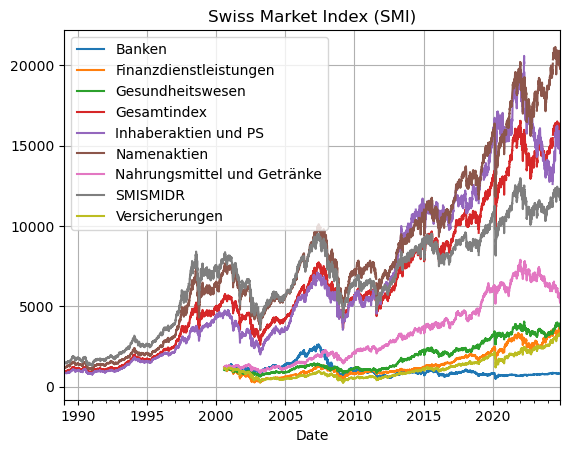

In [3]:
raw.plot(grid=True, title="Swiss Market Index (SMI)")
plt.show()

In the rest of this analysis, we shall focus on the overall index "Gesamtindex" only:

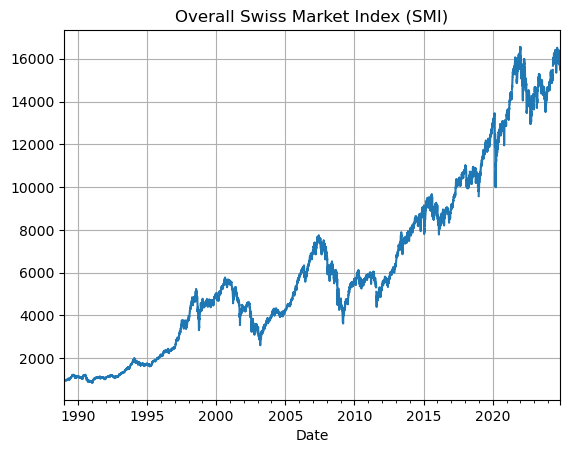

In [4]:
raw["Gesamtindex"].plot(grid=True, title="Overall Swiss Market Index (SMI)")
plt.show()

In [5]:
raw["Gesamtindex"].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 9360 entries, 1989-01-02 to 2024-11-15
Series name: Gesamtindex
Non-Null Count  Dtype  
--------------  -----  
9033 non-null   float64
dtypes: float64(1)
memory usage: 146.2 KB


From this we see that there are missing values. These we will need to handle later.

In [6]:
raw["Gesamtindex"].describe()

count     9033.000000
mean      6354.922799
std       4230.135638
min        843.500000
25%       3395.240000
50%       5451.590000
75%       8880.220000
max      16552.360000
Name: Gesamtindex, dtype: float64

### 1.2) Clean

First, handle the missing values by interpolating them linearly.

In [7]:
clean_data = raw["Gesamtindex"].interpolate()

Check if any missing values remain:

In [8]:
print(clean_data.isna().head())
print("No. of remaining missing values:", clean_data.isna().sum())

Date
1989-01-02     True
1989-01-03    False
1989-01-04    False
1989-01-05    False
1989-01-06    False
Name: Gesamtindex, dtype: bool
No. of remaining missing values: 1


Apparently, only one value is still missing. It could not be interpolated because it is the first value in the time series. We can simply drop this NaN-value without any relevant consequences. 

In [9]:
# Remove single remaining missing value
clean_data.dropna(inplace=True)

### 1.3) Check if data is stationary & homoskedastic

A simple visual inspection is enough to demonstrate that the time series has a clear trend and thus is not stationary:

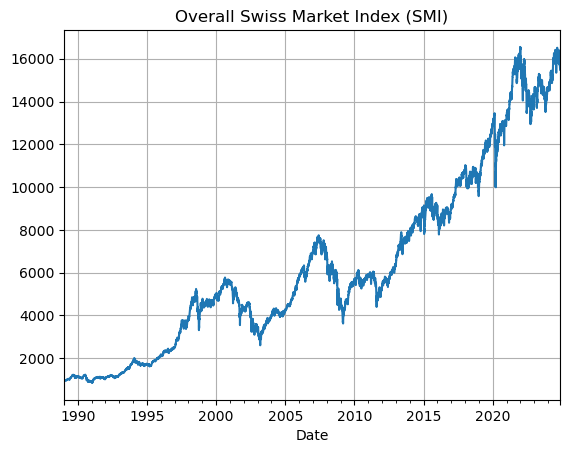

In [10]:
clean_data.plot(grid=True, title="Overall Swiss Market Index (SMI)")
plt.show()

However, we can use the augmented Dickey-Fuller test to confirm this in a quantitative approach:

In [11]:
adf = adfuller(clean_data)

print("Augmented DF results:")
print("---------------------")
print(f"ADF statistic: {adf[0]}")
print(f"p-value: {adf[1]}")

Augmented DF results:
---------------------
ADF statistic: 0.6125921277765215
p-value: 0.9879219258821984


The augmented Dickey-Fuller test returns a very large p-value, implying that we cannot reject the null-hypothesis saying that the time series is not stationary. This corresponds with the expectation based on the visiual inspection above.

However, the question remains, if the time series is stationary after differencing:

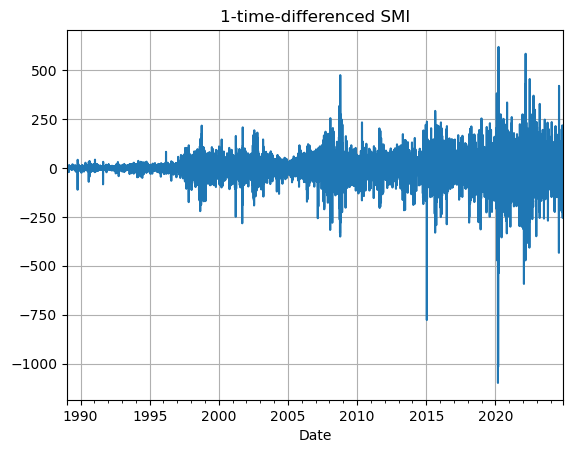

In [20]:
smi_diff = clean_data.diff().dropna()
smi_diff.plot(grid=True, title="1-time-differenced SMI")
plt.show()

In [21]:
adf_diff = adfuller(smi_diff)

print("Augmented DF results:")
print("---------------------")
print(f"ADF statistic: {adf_diff[0]}")
print(f"p-value: {adf_diff[1]}")

Augmented DF results:
---------------------
ADF statistic: -17.859997418288692
p-value: 3.0559437669817933e-30


This result tells us that after differencing once, there is no left-over trend, the mean is constant and the original data is trend-stationary. However, the graphic suggests that the data is heteroskedastic.

In [22]:
arch_test = het_arch(smi_diff)

print("ARCH test results:")
print("---------------------")
print(f"ARCH statistic: {arch_test[0]}")
print(f"p-value: {arch_test[1]}")

ARCH test results:
---------------------
ARCH statistic: 2100.3119836938513
p-value: 0.0


The large value of the test statistic and the vanishing p-value confirm that there is strong heteroskedasticity present in the data.

#### CONCLUSION: A simple ARIMA model is not enough to model this time series. We will have to model the variance explicitly using a GARCH approach.

### 1.4) Distribution and outlier analysis

Let's take a look at how the differenced time series values are distributed:

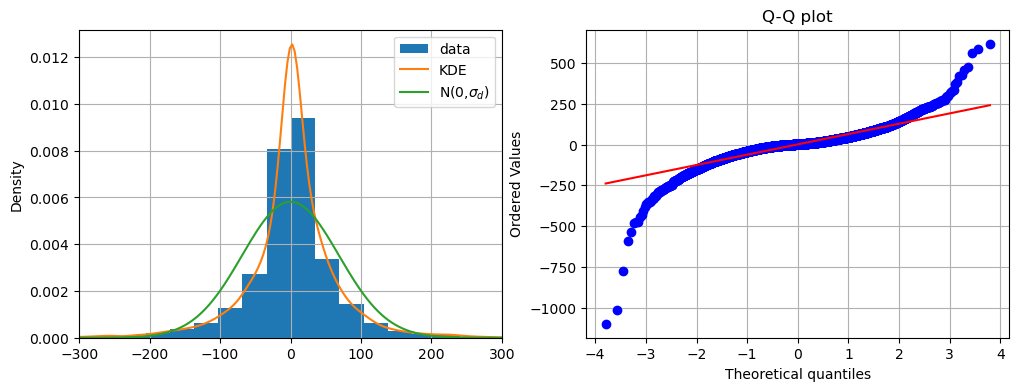

In [89]:
x_min, x_max = -300,300
x = np.linspace(x_min,x_max, 1000)

fig, axs = plt.subplots(1,2, figsize=(12,4))
ax = axs[0]
smi_diff.hist(ax=ax, density=True, bins=50, label="data")
smi_diff.plot.kde(ax=ax, label="KDE")
ax.plot(x, norm.pdf(x, scale=smi_diff.std()), label=r"N(0,$\sigma_d$)")
ax.legend(loc="best")
ax.grid(True)
ax.set_xlim([x_min,x_max])

ax = axs[1]
probplot(smi_diff, plot=ax)
ax.grid(True)
ax.set_title("Q-Q plot")

plt.show()

This analysis shows clearly that the values of the differenced time series are not normally distributed but are heavily leptokurtic (strongly peaked with heavy tails). Let's try to transform the data to become more normally distributed:

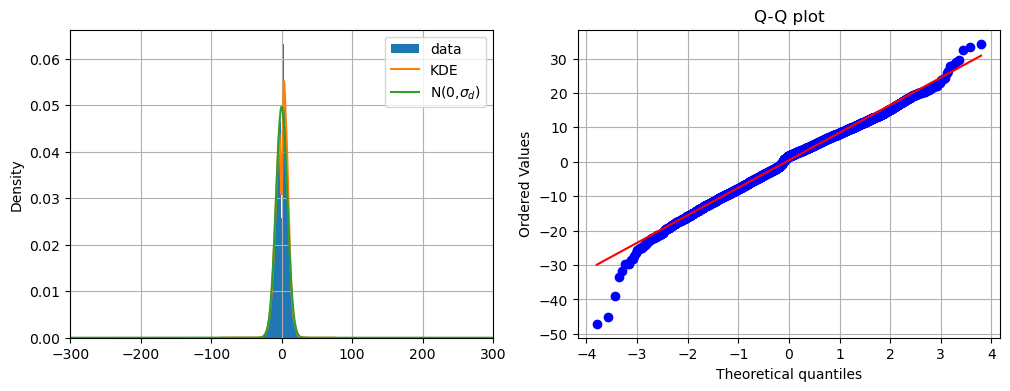

In [110]:
trf = lambda x: np.sign(x)*np.abs(x)**(0.55)
trf_data = smi_diff.apply(trf)

x_min, x_max = -300,300
x = np.linspace(x_min,x_max, 1000)

fig, axs = plt.subplots(1,2, figsize=(12,4))
ax = axs[0]
trf_data.hist(ax=ax, density=True, bins=50, label="data")
trf_data.plot.kde(ax=ax, label="KDE")
ax.plot(x, norm.pdf(x, scale=trf_data.std()), label=r"N(0,$\sigma_d$)")
ax.legend(loc="best")
ax.grid(True)
ax.set_xlim([x_min,x_max])

ax = axs[1]
probplot(trf_data, plot=ax)
ax.grid(True)
ax.set_title("Q-Q plot")

plt.show()

## 2) Time Series Modeling

### 2.1) Split data into training and validation set

In order to make sure that we will be able to test the performance of the resulting model, we need to split our data set into a training and a validation set.

In [112]:
n_data = len(smi_diff)

tr_val_split = 0.8
size_tr = int(np.floor(tr_val_split * n_data))
size_val = n_data - size_tr

print(f"Size of training data set: {int(size_tr)} data points")
print(f"Size of validation data set: {int(size_val)} data points")

Size of training data set: 7486 data points
Size of validation data set: 1872 data points


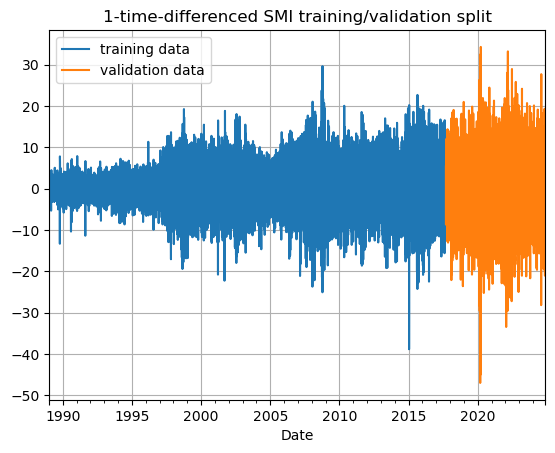

In [114]:
smi_training = trf_data.iloc[:size_tr]#smi_diff.iloc[:size_tr]
smi_val = trf_data.iloc[size_tr:]#smi_diff.iloc[size_tr:]

fig, ax = plt.subplots()
smi_training.plot(title="1-time-differenced SMI training/validation split", ax=ax, label="training data")
smi_val.plot(grid=True, ax=ax, label="validation data")
ax.legend(loc="best")
plt.show()

### 2.2) Modeling of ARIMA component

In order to get some initial insight into what the orders of p and q of the AR and the MA components are, we look at the autocorrelation and the partial autocorrelation of the the differenced time series:

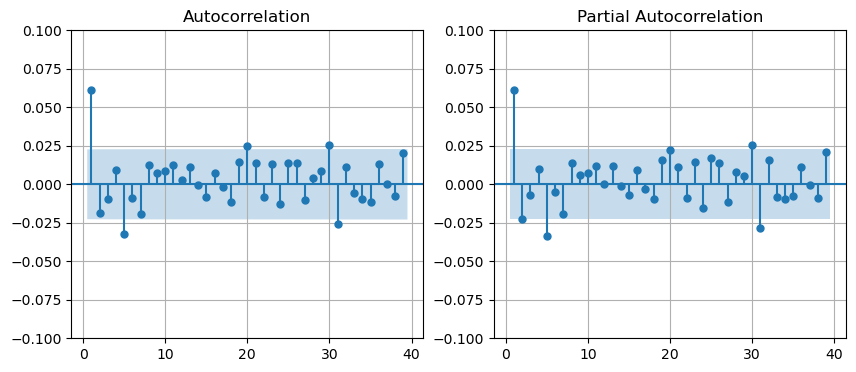

In [115]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
ax = axs[0]
plot_acf(smi_training, zero=False, ax=ax)
ax.grid(True)
ax.set_ylim([-0.1, 0.1])

ax = axs[1]
plot_pacf(smi_training, zero=False, ax=ax)
ax.grid(True)
ax.set_ylim([-0.1, 0.1])
plt.show()

Based on the autocorrelation and partial autocorrelation functions, it is not entirely clear what the order p and q of the ARIMA components should be. For this reason, we identify the values of these parameters using a grid search:

In [116]:
autoopt_model = pm.auto_arima(smi_training, stepwise=True, stationary=True)

In [117]:
print("Optimal model:")
print("--------------")
print("ARIMA model order:", autoopt_model.order)
print("Summary:")
print(autoopt_model.summary())

Optimal model:
--------------
ARIMA model order: (2, 0, 2)
Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7486
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -25154.719
Date:                Thu, 02 Jan 2025   AIC                          50321.439
Time:                        11:15:57   BIC                          50362.964
Sample:                    01-04-1989   HQIC                         50335.699
                         - 09-13-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1400      0.239      4.774      0.000       0.672       1.608
ar.L1         -1.2388      0.103    -12.024      0.000      -1.

Let's interpret this result summary:

1) As expected, we find a model that is well capable of capturing the autocorrelation structure of the time series: the p-value of the Ljung-Box test is close to 1. The null-hypothesis of the Ljung-Box test says that there is no correlation between the residuals. The high p-value tells us that this null-hypothesis cannot be rejected, in other words: all the correlation is accounted for by the ARIMA model itself). 

2) The results of the Jarque-Bera test tell us that the residuals are not normally distributed. The null-hypothesis saying that the residuals *are* normally distributed can be strongly rejected given the vanishing p-value.

3) We also get yet another confirmation that the data is strongly heteroskedastic (H>3), as the corresponding test leads to the conclusion that the null-hypothesis of the data being homoskedastic can be clearly rejected.

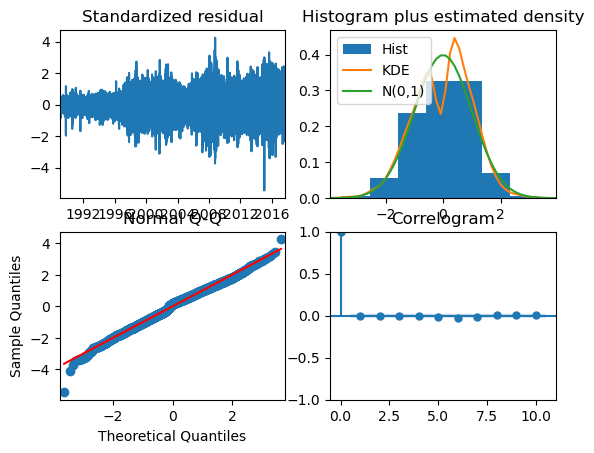

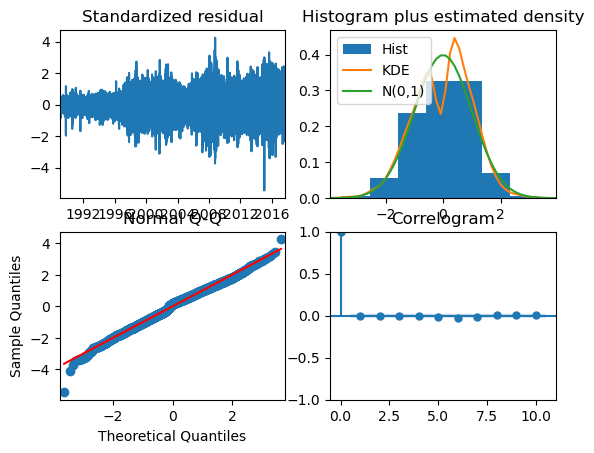

In [118]:
autoopt_model.plot_diagnostics()

### 2.4) Explicit modeling of variance using GARCH

### 2.5) Recombine trend, ARIMA and GARCH into single model